In [51]:
import pandas as pd
import numpy as np

In [20]:
tweets = pd.read_csv("tweets.csv")

In [4]:
import emoji
def deEmoji(text):
    return emoji.get_emoji_regexp().sub(r'', text)

In [5]:
# Preprocess
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

def text_preprocess(text):
    text = re.sub(r'#', '', text) #Replace the # symbol with '' in every tweet
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text) #Replace hyperlinks with '' in every tweet
    text = re.sub(r'[^\w\d\s]+', '', text) #Remove all punctuations
    text = deEmoji(text) #Remove emoji
    text = re.sub(r'\n', '', text) #Remove \n
    
    #Remove all stopwords
    stopwords_eng = stopwords.words('english')
    pattern = re.compile(r'\b(' + r'|'.join(stopwords_eng) + r')\b\s*')
    text = pattern.sub('', text)
    
    #Apply stem
    ps = PorterStemmer()
    tk = TweetTokenizer(preserve_case=False, strip_handles = True)
    tweet_tokens = tk.tokenize(text)
    tweet_finish = ''
    for token in tweet_tokens:
        stem = ps.stem(token)
        tweet_finish += (stem + ' ')
    return tweet_finish  

In [22]:
tweets = tweets[['medical_device', 'text']]

In [23]:
tweets

,medical_device,text
0,False,Y’all know and I know I’m never leaving this b...
1,False,@SuperKelli24 Such a funny scene! #JnJ
2,False,"J&amp;JOHNSON, Flag-Formation Confirmed, Conti..."
3,False,$JNJ's daily RSI hasn't touched 69 since its F...
4,False,We have an outstanding opportunity to join our...
...,...,...
4635,True,Cardiac Mapping Market\nhttps://t.co/oBNqvTHD3W
4636,False,@ForegutSociety @JNJInstitute @Ethicon @Proxim...
4637,False,Get ready to watch at 8.00pm (Beijing Time) Th...
4638,False,🔛 WELCOME to the #webinar The Chinese Perspect...


In [24]:
length = len(tweets.text)
for i in range(length):
    tweets.text.iloc[i] = text_preprocess(tweets.text.iloc[i])

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [25]:
tweets

,medical_device,text
0,False,yall know i know im never leav boy alon jnj
1,False,superkelli 24 such funni scene jnj
2,False,jampjohnson flagform confirm continu possibl j...
3,False,jnj daili rsi hasnt touch 69 sinc februari 202...
4,False,we outstand opportun join non clinic safeti te...
...,...,...
4635,True,cardiac map market
4636,False,foregutsocieti jnjinstitut ethicon proximiear ...
4637,False,get readi watch 800pm beij time the chines per...
4638,False,welcom webinar the chines perspect vat left up...


In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

x=tweets['medical_device'].value_counts()
print(x)

False    4157
True      483
Name: medical_device, dtype: int64


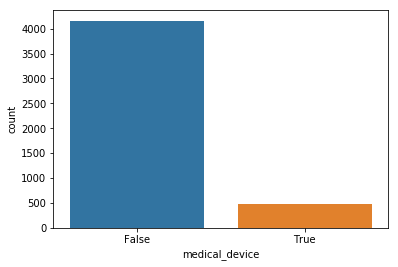

In [34]:
ax = sns.countplot(x="medical_device", data=tweets)

In [47]:
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets

# create Word2vec model
#here words_f should be a list containing words from each document. say 1st row of the list is words from the 1st document/sentence
#length of words_f is number of documents/sentences in your dataset
tweets['clean_text_tok']=[nltk.word_tokenize(i) for i in tweets['text']] #convert preprocessed sentence to tokenized sentence
model = Word2Vec(tweets['clean_text_tok'],min_count=1)  #min_count=1 means word should be present at least across all documents,
#if min_count=2 means if the word is present less than 2 times across all the documents then we shouldn't consider it


w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))  #combination of word and its vector

#for converting sentence to vectors/numbers from word vectors result by Word2Vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tweets["text"], tweets["medical_device"],
                                                    test_size=0.2,
                                                    shuffle=True, 
                                                    stratify=tweets["medical_device"],
                                                    random_state=42)

In [49]:
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [53]:
modelw = MeanEmbeddingVectorizer(w2v)
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_test_vectors_w2v = modelw.transform(X_test_tok)

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# LR (tf-idf)

In [56]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)

lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
 

print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

              precision    recall  f1-score   support

       False       0.95      0.99      0.97       831
        True       0.84      0.60      0.70        97

    accuracy                           0.95       928
   macro avg       0.90      0.79      0.83       928
weighted avg       0.94      0.95      0.94       928

Confusion Matrix: [[820  11]
 [ 39  58]]
AUC: 0.9773716922847892


# NB (tf-idf)

In [57]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
#It's a probabilistic classifier that makes use of Bayes' Theorem, a rule that uses probability to make predictions based on prior knowledge of conditions that might be related. This algorithm is the most suitable for such large dataset as it considers each feature independently, calculates the probability of each category, and then predicts the category with the highest probability.

nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
 

print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

              precision    recall  f1-score   support

       False       0.90      1.00      0.95       831
        True       0.89      0.08      0.15        97

    accuracy                           0.90       928
   macro avg       0.90      0.54      0.55       928
weighted avg       0.90      0.90      0.87       928

Confusion Matrix: [[830   1]
 [ 89   8]]
AUC: 0.9394593521654447


# LR (w2v)

In [58]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression (W2v)
lr_w2v=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_w2v.fit(X_train_vectors_w2v, y_train)  #model

#Predict y value for test dataset
y_predict = lr_w2v.predict(X_test_vectors_w2v)
y_prob = lr_w2v.predict_proba(X_test_vectors_w2v)[:,1]
 

print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

              precision    recall  f1-score   support

       False       0.90      1.00      0.94       831
        True       0.00      0.00      0.00        97

    accuracy                           0.89       928
   macro avg       0.45      0.50      0.47       928
weighted avg       0.80      0.89      0.85       928

Confusion Matrix: [[830   1]
 [ 97   0]]
AUC: 0.8350515463917525
